### Setup and index
Select a single measurement from database

In [1]:
import lib.csv_helpers as csv
import lib.data_process 
import lib.json_setup as json_setup
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# change directory to wherever you have your setup and data folders
os.chdir('/Users/calum/Desktop/spectrometer')

# select the appropriate setup file, and read it in
setup_path = "setup/20220818_s44077.json"
setup = json_setup.json_to_dict(setup_path)

# Read in the index file of the metadata 
meta_df = csv.read_metadata(setup)

# Filter for the measurement you are interested in
meta_df = csv.select_from_metadata('fluid', 'Air', meta_df)
# meta_df = csv.select_from_metadata('element', 'A01', meta_df)
meta_df

INFO:root:filtering by metadata "fluid" == "Air"


,date,instrument,sensor,element,structure,surface,fluid,repeats,comment
index,,,,,,,,,
s44077_pre-iDOT-A01-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,A01,-,[,Air,3,<NA>
s44077_pre-iDOT-A02-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,A02,-,[,Air,3,<NA>
s44077_pre-iDOT-A03-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,A03,-,[,Air,3,<NA>
s44077_pre-iDOT-A04-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,A04,-,[,Air,3,<NA>
s44077_pre-iDOT-A05-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,A05,-,[,Air,3,<NA>
...,...,...,...,...,...,...,...,...,...
s44077_pre-iDOT-E12-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,E12,-,[,Air,3,<NA>
s44077_pre-iDOT-E13-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,E13,-,[,Air,3,<NA>
s44077_pre-iDOT-E14-Air,2022-08-18,broadbandLED_instrument,s44077_pre-iDOT,E14,-,[,Air,3,<NA>


In [2]:
# select the appropriate setup file, and read it in
setup_path = "setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)

# Read in the index file of the metadata 
meta_df = csv.read_metadata(setup)

# Filter for the measurement you are interested in
meta_df = csv.select_from_metadata('sensor', 'HAN24', meta_df)
meta_df = csv.select_from_metadata('fluid', 'BeerBitter1', meta_df)
meta_df = csv.select_from_metadata('element', '15', meta_df)
meta_df


INFO:root:filtering by metadata "sensor" == "HAN24"
INFO:root:filtering by metadata "fluid" == "BeerBitter1"
INFO:root:filtering by metadata "element" == "15"


,date,instrument,sensor,element,structure,surface,fluid,repeats,comment
index,,,,,,,,,
HAN24-15-BeerBitter1,2022-03-30,default_instrument,HAN24,15,<NA>,<NA>,BeerBitter1,6,<NA>


### Process data

Apply any desired processing options (as defined in the data_process.py file)

In [3]:

# Read in the actual spectral data, merging all measurements into a single dataframe
merged_df, title = csv.merge_dataframes(setup, meta_df)

# Configure the parameters for processing the data
dp = lib.data_process.DataProcessor()
dp.apply_avg_repeats = True
dp.apply_normalise = True
dp.apply_smooth = False
dp.apply_trim = False
dp.apply_interpolate = False
dp.apply_round = True

dp.smooth_points = 3
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3

# Apply the processing
df = dp.process_dataframe(merged_df)
df

,avg
wavelength,
457.131,0.958
457.204,0.941
457.277,0.775
457.349,0.741
457.422,0.727
...,...
730.534,0.674
730.598,0.679
730.661,0.696


In [4]:
# Try using only the wavelengths available via A7263
# 610nm, 680nm, 730nm, 760nm, 810nm, 860nm

target_wavelengths = [450, 500, 550, 570, 600, 650] # A7262
target_wavelengths = [610, 680, 730, 760, 810, 860] # A7263
target_wavelengths = [450, 475, 515, 555, 550, 600, 640, 690, 745, 855] # AS7343
target_wavelengths = [500, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900, 940 ]# AS72651 + AS72652

# Create a series of available wavelengths
wl_series = df.index.to_series().reset_index(drop=True)

indices = []

for wl in target_wavelengths:
    # find the index of the closest wavelength to the target one
    ix = (wl_series - wl).abs().idxmin()
    indices.append(ix)
    
# Select only those rows from the dataframe
stripped_df = df.iloc[indices]

stripped_df


,avg
wavelength,
499.988,0.727
559.972,0.944
585.014,0.996
609.976,0.839
645.026,0.243
679.999,0.051
704.977,0.359
730.030,0.641
730.787,0.676


### Plot

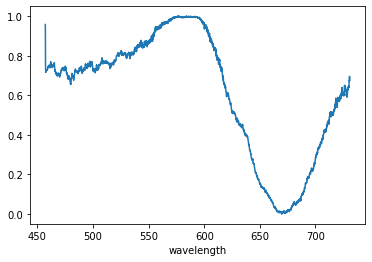

In [6]:
df.plot(legend=False)
df.to_csv('/Users/calum/git/dwt-optical/df.csv')

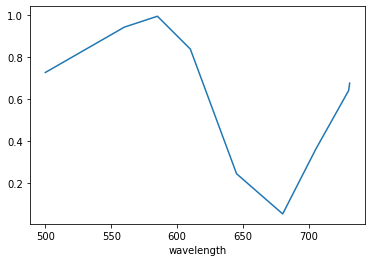

In [7]:

stripped_df.plot(legend=False)
stripped_df.to_csv('/Users/calum/git/dwt-optical/stripped_df.csv')

Curve fitting avg in thread
popt=array([ 9.75230989e-01,  3.66845334e-03,  4.45324781e+00,  5.56784991e-01,
        9.75459010e-03,  3.07567633e+00,  1.25470478e-01,  5.35406620e-02,
       -5.96687475e+00,  7.98456783e-02,  6.94271949e-02, -6.37618429e-01,
        3.89228962e-01,  3.37190205e-02, -5.05512511e+00,  7.10500613e-02,
        5.33972190e-02,  3.57398087e-01,  1.41830362e-01,  9.67621884e-02,
       -8.16537624e+00,  1.84101032e-01,  1.24396964e-01, -9.60794892e+00])
Finished curve fitting avg


<AxesSubplot:xlabel='wavelength'>

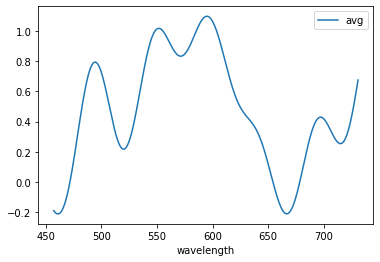

In [8]:


from scipy.optimize import curve_fit, OptimizeWarning
from threading import Thread

import warnings
import numpy as np


# a1 = 0.9646    
# a2 = 0.0051    
# c1  =  4.4570    
# a2  =  0.5733    
# b2  =  0.0121    
# c2  =  3.0772    
# a3  =  0.0780    
# b3  =  0.0549    
# c3  =  -5.9688   
# a4  =  0.0490    
# b4  =  0.0756    
# c4  =  -0.6380   
# a5  =  0.1936    
# b5  =  0.0342    
# c5  =  -5.0527   
# a6  =  0.0231    
# b6  =  0.0548    
# c6  =  0.3564    
# a7  =  0.0221    
# b7  =  0.0967    
# c7  =  -8.1657   
# a8  =  0.0079    
# b8  =  0.1180    
# c8  =  -9.6075   


initial = [0.9646,    
0.0051,    
4.4570 ,   
0.5733 ,   
0.0121 ,   
3.0772 ,   
0.0780 ,   
0.0549 ,   
-5.9688,   
0.0490 ,   
0.0756 ,   
-0.6380,   
0.1936 ,   
0.0342 ,   
-5.0527,   
0.0231 ,   
0.0548 ,   
0.3564 ,   
0.0221 ,   
0.0967 ,   
-8.1657,   
0.0079 ,   
0.1180 ,   
-9.6075]

def fitted_sine_list(x, coeff_list):
    a1 = coeff_list[0]
    b1 = coeff_list[1]
    c1 = coeff_list[2]
    a2 = coeff_list[3]
    b2 = coeff_list[4]
    c2 = coeff_list[5]
    a3 = coeff_list[6]
    b3 = coeff_list[7]
    c3 = coeff_list[8]
    a4 = coeff_list[9]
    b4 = coeff_list[10]
    c4 = coeff_list[11]
    a5 = coeff_list[12]
    b5 = coeff_list[13]
    c5 = coeff_list[14]
    a6 = coeff_list[15]
    b6 = coeff_list[16]
    c6 = coeff_list[17]
    a7 = coeff_list[18]
    b7 = coeff_list[19]
    c7 = coeff_list[20]
    a8 = coeff_list[21]
    b8 = coeff_list[22]
    c8 = coeff_list[23]

    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4) + a5*np.sin(b5*x+c5) + a6*np.sin(b6*x+c6) + a7*np.sin(b7*x+c7) + a8*np.sin(b8*x+c8)
    return y

def fitted_sine(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5, a6, b6, c6, a7, b7, c7, a8, b8, c8):
    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4) + a5*np.sin(b5*x+c5) + a6*np.sin(b6*x+c6) + a7*np.sin(b7*x+c7) + a8*np.sin(b8*x+c8)
    return y

# Generate Ideal model from original spectrum, use this for starting coefficients
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore', OptimizeWarning)
#     popt, pcov = curve_fit(fitted_sine, wl_full, tr_full, p0=initial, maxfev=1000000)
#     fitted = fitted_sine_list(df.index.to_numpy(), popt)

def thread_task(col, fitted_df):
    print(f"Curve fitting {col} in thread")
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', OptimizeWarning)
        popt, pcov = curve_fit(
                            fitted_sine, stripped_df.index, stripped_df[col],
                            p0=initial,
                            maxfev=1000000,
                            method='trf',
                            # bounds=(0, [3, 1, 0.5])
                            )
    fitted = fitted_sine_list(df.index.to_numpy(), popt)
    print(f'{popt=}')
    fitted_df[col] = fitted
    print(f"Finished curve fitting {col}")

# curve fit the stripped data
fitted_df = pd.DataFrame(index=df.index, columns=df.columns)
threads = []
for col in stripped_df.columns:
    thread = Thread(target=thread_task, args=(col,fitted_df))
    thread.start()
    threads.append(thread)

for t in threads:
    t.join()


# stats_df = dp.get_stats(df)
# fitted_stats_df = dp.get_stats(fitted_df)

fitted_df
# plot_stats(df, fitted_df, stripped_df, title='Spectrometer Data', stats_df=None, fitted_stats_df=None)
# plot_stats(df, fitted_df, stripped_df, title='Spectrometer Data', stats_df=stats_df, fitted_stats_df=fitted_stats_df)

fitted_df.plot()

In [11]:


from scipy.optimize import curve_fit, OptimizeWarning
from threading import Thread

import warnings
import numpy as np

# Maybe try doing FFT first to get guess of frequencies

initial_values = [
-1,
0.01,
-0.5,

1,
0.0200,
-0.5000,

0.2,
0.0300,
-0.5000,

0.01,
0.0400,
-0.5000,
]

initial_values = [0.9646,    
0.0051,    
4.4570 ,   
0.5733 ,   
0.0121 ,   
3.0772 ,   
0.0780 ,   
0.0549 ,   
-5.9688,    
0.0490 ,   
0.0756 ,   
-0.6380]

def fitted_sine_list(x, coeff_list):
    a1 = coeff_list[0]
    b1 = coeff_list[1]
    c1 = coeff_list[2]
    a2 = coeff_list[3]
    b2 = coeff_list[4]
    c2 = coeff_list[5]
    a3 = coeff_list[6]
    b3 = coeff_list[7]
    c3 = coeff_list[8]
    a4 = coeff_list[9]
    b4 = coeff_list[10]
    c4 = coeff_list[11]

    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4)
    return y

def fitted_sine(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4):
    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4)
    return y

# Generate Ideal model from original spectrum, use this for starting coefficients
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore', OptimizeWarning)
#     popt, pcov = curve_fit(fitted_sine, wl_full, tr_full, p0=initial, maxfev=1000000)
#     fitted = fitted_sine_list(df.index.to_numpy(), popt)

def thread_task(col, fitted_df):
    print(f"Curve fitting {col} in thread")
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', OptimizeWarning)
        popt, pcov = curve_fit(
                            fitted_sine, stripped_df.index, stripped_df[col],
                            p0=initial_values,
                            maxfev=1000000,
                            method='trf',
                            # bounds=(
                            #     [-2, 0,   -np.inf,  -1.5,0.01,-np.inf, -0.5,0.02,-np.inf,     -0.1,0.03,-np.inf],
                            #     [ 2, 0.02, np.inf,  1.5,0.03,np.inf,  0.5,0.05,np.inf,  0.1,0.06,np.inf]
                            #     )
                            )
    fitted = fitted_sine_list(df.index.to_numpy(), popt)
    print(f'{popt=}')
    fitted_df[col] = fitted
    print(f"Finished curve fitting {col}")

# curve fit the stripped data
df = df[df.columns[0:1]]

fitted_df = pd.DataFrame(index=df.index, columns=df.columns)

for col in stripped_df.columns[0:1]:
    thread_task(col, fitted_df)
# threads = []
# for col in stripped_df.columns:
#     thread = Thread(target=thread_task, args=(col,fitted_df))
#     thread.start()
#     threads.append(thread)

# for t in threads:
#     t.join()


stats_df = dp.get_stats(df)
fitted_stats_df = dp.get_stats(fitted_df)

fitted_df
plot_stats(df, fitted_df, stripped_df, title='Spectrometer Data', stats_df=stats_df, fitted_stats_df=fitted_stats_df)


Curve fitting avg in thread
popt=array([ 7.34969687e+00,  3.54951609e-03,  4.16825773e+00,  3.00379162e+00,
        1.11055572e-02,  2.56352519e+00,  3.77488431e-01,  4.62331052e-02,
       -1.16570196e+00,  3.43760725e-01,  1.02286786e-01, -1.88553431e+01])
Finished curve fitting avg


In [12]:
stats_df = dp.get_stats(df)
fitted_stats_df = dp.get_stats(fitted_df)

In [27]:
popt=[ 9.75230989e-01,  3.66845334e-03,  4.45324781e+00,  5.56784991e-01,
        9.75459010e-03,  3.07567633e+00,  1.25470478e-01,  5.35406620e-02,
       -5.96687475e+00,  7.98456783e-02,  6.94271949e-02, -6.37618429e-01,
        3.89228962e-01,  3.37190205e-02, -5.05512511e+00,  7.10500613e-02,
        5.33972190e-02,  3.57398087e-01,  1.41830362e-01,  9.67621884e-02,
       -8.16537624e+00,  1.84101032e-01,  1.24396964e-01, -9.60794892e+00]

pd.Series(popt).abs().max()

pd.Series(initial).abs().max()

9.6075

<AxesSubplot:xlabel='wavelength'>

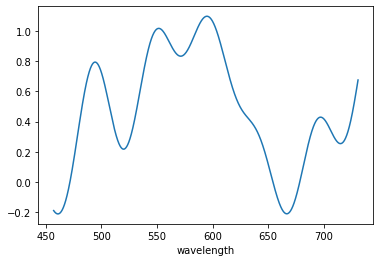

In [18]:
fitted_df.plot(legend=False)

<AxesSubplot:xlabel='wavelength'>

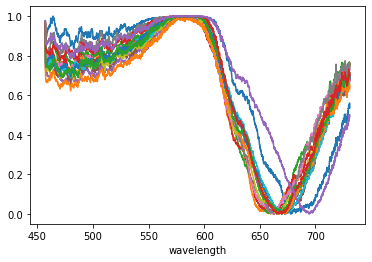

In [10]:
df.plot(legend=False)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure


def plot_stats(df, fitted_df, stripped_df, title=None, stats_df=None):

    # Create a figure of size 8x6 inches, 80 dots per inch
    fig = plt.figure(figsize=(10, 7), dpi=80)
    axes = fig.add_subplot(111)
    fig.set_tight_layout(True)

    df[df.columns[-1]].plot(ax=axes)

    fitted_df[fitted_df.columns[-1]].plot(ax=axes, label='fitted')

    # stripped_df[stripped_df.columns[-1]].plot(ax=axes, label='stripped', color='red', style='o-', kind='scatter')
    plt.scatter(stripped_df.index, stripped_df[stripped_df.columns[-1]], marker='o', color='red', label='stripped')

    # df.plot(ax=axes,
    #         # x='wavelength', 
    #         title = title,
    #         legend = True)

    lines = axes.get_lines()

    if stats_df is not None:
        trans = df[df.columns[-1]]
        row = stats_df.index[-1]
        inflection_min = stats_df.loc[row]['Infl_L']
        inflection_max = stats_df.loc[row]['Infl_R']
        fwhm = stats_df.loc[row]['FWHM']
        peak = stats_df.loc[row]['Peak']
        height = stats_df.loc[row]['Height']

        # Recalculate some FWHM details to position lines on plot
        min = trans.min()
        half_max=min+height/2
        hm_range = trans[trans <= half_max].index
        
        axes.axvline(x=peak, label=f"Peak={peak}nm", color='r')
        # axes.axvline(x=inflection_min, label=f"Infl_L={inflection_min}nm", color='c')
        # axes.axvline(x=inflection_max, label=f"Infl_R={inflection_max}nm", color='c')
        axes.hlines(y=half_max, xmin=hm_range[0], xmax=hm_range[-1], label=f"FWHM={fwhm}nm", color='m')
        axes.axhline(y=min+height, label=f"Height={height}%", color='g')
        # draw()

    for legline, pltline in zip(axes.legend().get_lines(), lines):
        legline.set_picker(True)  # Enable picking on the legend lines.


    fig.show()
plot_stats(df, fitted_df, stripped_df, title='Spectrometer Data', stats_df=stats_df)


In [10]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



def plot_stats(df, fitted_df, stripped_df, title=None, stats_df=None, fitted_stats_df=None):

    cols_to_plot = []

    error_df = fitted_stats_df - stats_df
    max_peak_error_index = error_df['Peak'].abs().idxmax()
    min_peak_error_index = error_df['Peak'].abs().idxmin()
    cols_to_plot.append(max_peak_error_index)
    cols_to_plot.append(min_peak_error_index)

    fig = go.Figure()
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Max delta {max_peak_error_index}", f"Min delta {min_peak_error_index}"))

    subplot = 0
    for name in cols_to_plot:
        subplot += 1
        fig.add_scatter(x=df.index, y=df[name], line_color='blue', mode='lines', name='Orig Spectrum', line=dict(width=1), row=1, col=subplot)
        fig.add_scatter(x=stripped_df.index, y=stripped_df[name] ,name='stripped', mode='markers', marker_color='red', row=1, col=subplot)
        fig.add_scatter(x=fitted_df.index, y=fitted_df[name] ,name='fitted', mode='lines', line_color='orange', line=dict(width=1), row=1, col=subplot)

        if stats_df is not None:
            fig.add_vline(x=stats_df.loc[name]['Peak'],
                        line_color='blue',
                        line_width=1,
                        row=1, col=subplot)
            
            # Recalculate some FWHM details to position lines on plot
            spectrum = df[name]
            min = spectrum.min()
            height = stats_df.loc[name]['Height']
            half_max=min+height/2
            hm_range = spectrum[spectrum <= half_max].index
            
            fig.add_shape(type="line",
                row=1, col=subplot,
                y0=half_max,
                y1=half_max,
                x0=hm_range[0],
                x1=hm_range[-1],
                line=dict(
                    color="Purple",
                    width=1,
                ))
            
            fig.add_hline(
                y=min+height,
                row=1, col=subplot,
                line_color='green',
                line_width=1)

        if fitted_stats_df is not None:
            delta_peak = fitted_stats_df.loc[name]['Peak'] - stats_df.loc[name]['Peak']
            delta_fwhm = fitted_stats_df.loc[name]['FWHM'] - stats_df.loc[name]['FWHM']
            delta_height = fitted_stats_df.loc[name]['Height'] - stats_df.loc[name]['Height']

            fig.add_vline(x=fitted_stats_df.loc[name]['Peak'], 
                        line_color='orange',
                        line_width=1,
                        row=1, col=subplot,
                        annotation=dict(
                            text=f"dPeak<br>={delta_peak:.2f}nm",
                            xanchor="left",
                            xshift=10,
                            opacity=0.7),
                            )
            
            # Recalculate some FWHM details to position lines on plot
            spectrum = fitted_df[name]
            min = spectrum.min()
            height = fitted_stats_df.loc[name]['Height']
            half_max=min+height/2
            hm_range = spectrum[spectrum <= half_max].index
            
            fig.add_shape(type="line",
                row=1, col=subplot,
                y0=half_max,
                y1=half_max,
                x0=hm_range[0],
                x1=hm_range[-1],
                line=dict(
                    color="Purple",
                    width=1),
                )


            fig.add_annotation(
                text=f"dFWHM<br>={delta_fwhm:.2f}nm",
                row=1, col=subplot,
                x=hm_range[0], y=half_max,
                showarrow=False,
                xanchor="right",
                xshift=-10,
                yshift=0,
                opacity=0.7,
            )
            
            fig.add_hline(
                y=min+height,
                row=1, col=subplot,
                line_color='green',
                line_width=1,
                annotation=dict(
                    text=f"dHeight={delta_height:.2f}",
                    xanchor="right",
                    xshift=-10,
                    opacity=0.7),
                )

    fig.show()

plot_stats(df, fitted_df, stripped_df, title='Spectrometer Data', stats_df=stats_df, fitted_stats_df=fitted_stats_df)


In [11]:
error_df = (fitted_stats_df-stats_df) / stats_df * 100

# find the maximum error in the error dataframe
max_error = error_df.abs().max().max()
print(f'{max_error=}')


# # print(f'{error_df.abs().max()=}')
# error_df.abs()['Peak']

# # get the index of the maximum value of the peak column
max_peak_error_index = error_df['FWHM'].abs().idxmax()
print(f'{max_peak_error_index=}')
# print(f'{max_error=}')

# # # find the average error in the peak column in the error dataframe
# max_peak_error = error_df['Peak'].abs().max()
# print(f"Max peak error: {max_peak_error:.4f}%")

max_error=6.955609926599099
max_peak_error_index='A08__avg'


In [28]:
import importlib
importlib.reload(lib.csv_helpers)

# select the appropriate setup file, and read it in
setup_path = "setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)

# Read in the index file of the metadata 
meta_df = csv.read_metadata(setup)

# Filter for the measurement you are interested in
meta_df = csv.select_from_metadata('sensor', 'HAN24', meta_df)
meta_df = csv.select_from_metadata('fluid', 'BeerBitter1', meta_df)
meta_df = csv.select_from_metadata('element', '10', meta_df)
meta_df

df = csv.merge_dataframes(setup, meta_df)
df
# setup

INFO:root:filtering by metadata "sensor" == "HAN24"
INFO:root:filtering by metadata "fluid" == "BeerBitter1"
INFO:root:filtering by metadata "element" == "10"


{'name': 'HAN24', 'category': 'setup', 'metafile': 'index.txt', 'datadir': 'HAN24data', 'subdirs': ['sensor', 'fluid'], 'primary_metadata': ['sensor', 'element', 'fluid'], 'instrument': {'name': 'default_instrument', 'category': 'instrument', 'light Source': 'Stellarnet LED White', 'spectrometer': 'Stellarnet BlueWave VIS-25'}, 'sensor': {'name': 'HAN24', 'category': 'sensor', 'layout': {'name': 'HAN24_layout', 'category': 'layout', 'map': {'01': ['', ''], '02': ['', ''], '03': ['', ''], '04': ['', ''], '05': ['', ''], '06': ['', ''], '07': ['', ''], '08': ['', ''], '09': ['', ''], '10': ['', ''], '11': ['', ''], '12': ['', ''], '13': ['', ''], '14': ['', ''], '15': ['', '']}}, 'structure_map': {'name': 'HAN24_structure', 'category': 'structure_map', 'valid_layout': 'HAN24_layout', 'map': {'01': ['', ''], '02': ['', ''], '03': ['', ''], '04': ['', ''], '05': ['', ''], '06': ['', ''], '07': ['', ''], '08': ['', ''], '09': ['', ''], '10': ['', ''], '11': ['', ''], '12': ['', ''], '13': [

(            rep01_  rep02_  rep03_  rep04_  rep05_  rep06_
 wavelength                                                
 457.131      98.77   99.22   98.77   98.48   98.74   98.66
 457.204      99.00   99.16   98.96   98.66   98.69   98.67
 457.277      95.12   95.17   94.66   91.41   90.84   90.74
 457.349      93.82   93.88   93.54   90.59   90.24   90.15
 457.422      93.98   94.03   93.78   91.22   90.90   90.74
 ...            ...     ...     ...     ...     ...     ...
 730.534      66.20   65.54   66.02   65.45   66.17   65.51
 730.598      66.68   66.14   66.71   66.65   66.32   66.26
 730.661      67.71   67.92   67.83   67.16   67.43   67.95
 730.724      66.41   67.32   66.72   65.54   66.87   67.35
 730.787      66.31   65.35   66.13   65.59   65.86   65.50
 
 [4095 rows x 6 columns],
 'sensor: HAN24\nelement: 10\nfluid: BeerBitter1')

In [41]:
stripped_df = stripped_df[stripped_df.index < 730.5]

result.x=array([-1.46496689e+00,  5.52028839e-03,  4.35552868e-01,  9.92391396e-01,
        1.19882318e-02,  2.41558555e+00, -2.77020678e-01,  3.60056782e-02,
       -9.97129377e+00, -8.77601264e-02,  5.99999968e-02, -1.32108014e+01])


<AxesSubplot:xlabel='wavelength'>

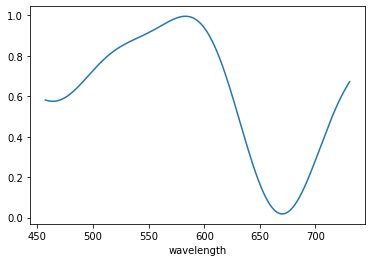

In [20]:

import numpy as np
# from scipy.stats import chi2
from scipy.optimize import least_squares




def objective(coeff_list):

    x = stripped_df.index

    a1 = coeff_list[0]
    b1 = coeff_list[1]
    c1 = coeff_list[2]
    a2 = coeff_list[3]
    b2 = coeff_list[4]
    c2 = coeff_list[5]
    a3 = coeff_list[6]
    b3 = coeff_list[7]
    c3 = coeff_list[8]
    a4 = coeff_list[9]
    b4 = coeff_list[10]
    c4 = coeff_list[11]

    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4)

    return stripped_df[stripped_df.columns[0]] - y


# initial_values = [
#     0.8188,
#     0.0088,
#     2.1073,
#     0.6318,
#     0.0231,
#     1.7323,
#     0.1665,
#     0.0535,
#     0.4514,
#     0.0008,
#     0.0821,
#     -2.2181]

initial_values = [
-1,
0.01,
-0.5,

1,
0.0200,
-0.5000,

0.2,
0.0300,
-0.5000,

0.01,
0.0400,
-0.5000,
]

# initial_values = [1, 0.01, -0.5, 0.5, 0.4, 0.1, 0.3, 0.7, 0.2, 0.5, 0.5, 0.5]
bounds=(
    # [0,0,0,0,0,0,0,0,0,0,0,0],
    # [-np.inf,0,-np.inf,    -np.inf,0,-np.inf,     -np.inf,0,-np.inf,     -np.inf,0,-np.inf],
    # [np.inf,np.inf,np.inf,  np.inf,np.inf,np.inf,  np.inf,np.inf,np.inf,  np.inf,np.inf,np.inf]
    [-2, 0,   -np.inf,  -1.5,0.01,-np.inf, -0.5,0.02,-np.inf,     -0.1,0.03,-np.inf],
    [ 2, 0.02, np.inf,  1.5,0.03,np.inf,  0.5,0.05,np.inf,  0.1,0.06,np.inf]
    )


result = least_squares(fun=objective,
                       x0=initial_values,
                    #    method='trf',
                       bounds=bounds)

result.x

def fitted_sine_list(x, coeff_list):
    a1 = coeff_list[0]
    b1 = coeff_list[1]
    c1 = coeff_list[2]
    a2 = coeff_list[3]
    b2 = coeff_list[4]
    c2 = coeff_list[5]
    a3 = coeff_list[6]
    b3 = coeff_list[7]
    c3 = coeff_list[8]
    a4 = coeff_list[9]
    b4 = coeff_list[10]
    c4 = coeff_list[11]

    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4)
    return y


# fitted = fitted_sine_list(df.index.to_numpy(), initial_values)
fitted = fitted_sine_list(df.index.to_numpy(), result.x)
print(f'{result.x=}')

type(fitted)
fitted = pd.Series(fitted, index=df.index)
fitted.plot()


In [27]:
stripped_df[stripped_df.columns[0]]

wavelength
499.988    0.727
559.972    0.944
585.014    0.996
609.976    0.839
645.026    0.243
679.999    0.051
704.977    0.359
730.030    0.641
730.787    0.676
730.787    0.676
730.787    0.676
730.787    0.676
730.787    0.676
Name: avg, dtype: float64

In [50]:
import serial
import serial.tools.list_ports   
import json
from json import JSONDecodeError
import lib.data_process 

import pandas as pd
from scipy.optimize import curve_fit, OptimizeWarning
import scipy.io



# Configure the parameters for processing the data
dp = lib.data_process.DataProcessor()
dp.apply_avg_repeats = False
dp.apply_normalise = True
dp.apply_smooth = False
dp.apply_trim = False
dp.apply_interpolate = False
dp.apply_round = True

def scan_serial_ports():
        ports = serial.tools.list_ports.comports()
        n =1 
        for port, desc, hwid in sorted(ports):
            print(f"{n}) {port}: {desc} [{hwid}]")
            n+=1
        return ports

ports = scan_serial_ports()

1) /dev/cu.Bluetooth-Incoming-Port: n/a [n/a]
2) /dev/cu.usbmodem003NTWG4H0092: USB Controls [USB VID:PID=043E:9A39 SER=003NTWG4H009 LOCATION=1-1.4]
3) /dev/cu.usbmodemC7FD1A6963641: Feather ESP32-S2 TFT [USB VID:PID=239A:8110 SER=C7FD1A696364 LOCATION=1-1.2.3]


In [15]:

import warnings
import numpy as np

# Maybe try doing FFT first to get guess of frequencies

initial_values = [
-1,
0.01,
-0.5,

1,
0.0200,
-0.5000,

0.2,
0.0300,
-0.5000,

0.01,
0.0400,
-0.5000,
]

initial_values = [0.9646,    
0.0051,    
4.4570 ,   
0.5733 ,   
0.0121 ,   
3.0772 ,   
0.0780 ,   
0.0549 ,   
-5.9688,    
0.0490 ,   
0.0756 ,   
-0.6380]

def fitted_sine_list(x, coeff_list):
    a1 = coeff_list[0]
    b1 = coeff_list[1]
    c1 = coeff_list[2]
    a2 = coeff_list[3]
    b2 = coeff_list[4]
    c2 = coeff_list[5]
    a3 = coeff_list[6]
    b3 = coeff_list[7]
    c3 = coeff_list[8]
    a4 = coeff_list[9]
    b4 = coeff_list[10]
    c4 = coeff_list[11]

    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4)
    return y

def fitted_sine(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4):
    y = a1*np.sin(b1*x+c1) + a2*np.sin(b2*x+c2) + a3*np.sin(b3*x+c3) + a4*np.sin(b4*x+c4)
    return y




In [84]:

port = serial.Serial("/dev/cu.usbmodemC7FD1A6963641", 115200, rtscts=True, timeout=0.1)


# port.open()
def get_sample(sensor_df=None):
    port.reset_input_buffer()
    port.reset_output_buffer()
    port.write('x'.encode('utf-8'))

    while (port.in_waiting == 0):
        pass

    line = port.readline().decode('utf-8').strip()
    try:
        sensor_dict = json.loads(line)

        if sensor_df is None:
            sensor_df = pd.DataFrame.from_dict(sensor_dict, orient='index', columns=['counts'])
            sensor_df.index = sensor_df.index.astype(float)
        else:
            sensor_df['counts'] = sensor_dict.values()

        sensor_df['FFS'] = sensor_df['counts'] / 65536 # as fraction of 16 bit count
        # sensor_df = dp.process_dataframe(sensor_df)
        return sensor_df
        
    except JSONDecodeError:
        print(f'JSONDecodeError: {line=}')
            # print(f'{sensor_df=}')        

def calculate_percentage(df):
    data = df['counts']
    lr = df['light_ref']
    dr = df['dark_ref']

    df['F_vs_refs'] = (data - dr) / (lr - dr)

    return df




In [94]:
# Capture_light_reference
sensor_df = get_sample()
sensor_df['light_ref'] = sensor_df['counts']
sensor_df['light_ref_FFS'] = sensor_df['FFS']

In [95]:
# Capture_dark_reference
df = get_sample()
sensor_df['dark_ref'] = df['counts']
sensor_df['dark_ref_FFS'] = df['FFS']

In [96]:
get_sample(sensor_df)
calculate_percentage(sensor_df)

# save as matlab format
d = sensor_df.to_dict()
for col in sensor_df.columns:
    d[col] = sensor_df[col].to_numpy()
d['index'] = sensor_df.index.to_numpy()
scipy.io.savemat('sensor_data.mat', d)

In [97]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=sensor_df.index, y=sensor_df['light_ref_FFS'] ,name='light_ref', mode='markers', marker_color='goldenrod')
fig.add_scatter(x=sensor_df.index, y=sensor_df['dark_ref_FFS'] ,name='dark_ref', mode='markers', marker_color='blue')
fig.add_scatter(x=sensor_df.index, y=sensor_df['FFS'] ,name='counts', mode='markers', marker_color='green')
fig.show() 
sensor_df  

,counts,FFS,light_ref,light_ref_FFS,dark_ref,dark_ref_FFS,F_vs_refs
610.0,91.7881,0.001401,61042.400,0.931433,1.10588,0.000017,0.001486
680.0,72.2615,0.001103,6304.300,0.096196,2.06461,0.000032,0.011138
730.0,91.0882,0.001390,1980.410,0.030219,2.27721,0.000035,0.044896
760.0,105.0970,0.001604,939.304,0.014333,4.10535,0.000063,0.107990
810.0,113.8730,0.001738,2572.850,0.039259,9.41809,0.000144,0.040748
860.0,126.4800,0.001930,894.392,0.013647,14.68070,0.000224,0.127086


In [98]:
from lib.stellarnet_spectrometer import Stellarnet_Spectrometer

spec = Stellarnet_Spectrometer()

spec.scans_to_avg = 3
spec.int_time = 450
spec.x_smooth = 1
spec.x_timing = 3
spec.wl_round = 2 #decimal places
spec.percentage_round = 3 #decimal places
spec.wl_min = 500 #optional wavelength trimming
spec.wl_max = 900

spec.connect()
spec.capture_dark_reference()
spec.capture_light_reference()
spectrum = spec.get_spectrum()
spectrum = spectrum / 100
spectrum

fig.add_scatter(x=spectrum.index, y=spectrum.iloc[:,0], line_color='blue', mode='lines', name='spectrometer', line=dict(width=1))
fig.show()


In [89]:
# Do Curve Fitting
initial_values = [0.9646,    
0.0051,    
4.4570 ,   
0.5733 ,   
0.0121 ,   
3.0772 ,   
0.0780 ,   
0.0549 ,   
-5.9688,    
0.0490 ,   
0.0756 ,   
-0.6380]

popt, pcov = curve_fit(
    fitted_sine, sensor_df.index, sensor_df[0],
    p0=initial_values,
    maxfev=1000000,
    method='trf',
    # bounds=(
    #     [-2, 0,   -np.inf,  -1.5,0.01,-np.inf, -0.5,0.02,-np.inf,     -0.1,0.03,-np.inf],
    #     [ 2, 0.02, np.inf,  1.5,0.03,np.inf,  0.5,0.05,np.inf,  0.1,0.06,np.inf]
    #     )
    )

# generate a numpy array between 600 and 900, with step 1
fitted_df = pd.DataFrame(index=np.arange(600, 900, 1))

fitted = fitted_sine_list(fitted_df.index.to_numpy(), popt)
fitted_df["fitted"] = fitted

fig.add_scatter(x=fitted_df.index, y=fitted_df.iloc[:,0] ,name='fitted', mode='lines', line_color='orange', line=dict(width=1))
fig.show()


KeyError: 0

In [ ]:


fig.add_scatter(x=df.index, y=df.iloc[:,0], line_color='blue', mode='lines', name='Orig Spectrum', line=dict(width=1))

In [ ]:
port.close()